# Kuzushiji-49: An Introduction to CNNs

## Part 2: Image Classification with CNNs in Keras

### Introduction

Now that we have explored the data and verified some assumptions, we will proceed in Part 2 to apply deep learning models for the purposes of image classification.

In this notebook we will be using [Keras](https://keras.io/getting_started/), which has been integrated into the [Tensorflow](https://www.tensorflow.org/) deep learning framework proper since Version 2.0. 

Because we will doing deep learning which is computationally expensive, we will also be leveraging the free GPU computing available from [Google Colab](https://colab.research.google.com/). This will require some additional code to move the data from local into the cloud (Google Drive) and also some additional code for rendering the hiragana in plots which differs from on my local machine. We will address these points as they arise in the workflow.

Before diving into the code and training the models, I will also take some time to briefly introduce and discuss the fundamentals of deep learning for computer vision at a high level.

As always, first we will load the regular core libraries of the data science stack:

In [1]:
# holy trinity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading the Data
As mentioned above, the data needed to be moved into the cloud in order to be read in Colab. Since the number of files and their sizes are relatively small, I simply uploaded these through the browser.



After this, we can mount Google Drive as a folder on the virtual machine backing the Colab notebook:

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


The files in Google Drive are now available in the filesystem of the virtual machine backing the Colab notebook at `/content/drive`. Let's just quickly check that all the data files are there by running a bash command using `!`:

In [3]:
!ls drive/MyDrive/kuzushiji/data/

k49_classmap.csv   k49-test-labels.npz	k49-train-labels.npz
k49-test-imgs.npz  k49-train-imgs.npz


Great, the files are there, so we can go ahead and load them all together in one cell:

In [4]:
# Reload the data

# Train
X_train = np.load('drive/MyDrive/kuzushiji/data/k49-train-imgs.npz')['arr_0']
y_train = np.load('drive/MyDrive/kuzushiji/data/k49-train-labels.npz')['arr_0']

# Test
X_test = np.load('drive/MyDrive/kuzushiji/data/k49-test-imgs.npz')['arr_0']
y_test = np.load('drive/MyDrive/kuzushiji/data/k49-test-labels.npz')['arr_0']

# Classmap
classmap = pd.read_csv('drive/MyDrive/kuzushiji/data/k49_classmap.csv')

### Adding a font for Japanese characters in Colab

Unfortunately, simply using the code which worked locally for displaying the hiragana will not work here, and this requires a little more doing. I followed the excellent guide here: [Using external fonts in Google Colaboratory](https://buomsoo-kim.github.io/colab/2018/04/27/Using-External-fonts-in-colab.md/). This follows a very similar procedure to the references pointed to in Part 1, through creating a `FontProperties` object in matplotlib, and then passing it to plotting / annotation / axis labeling / etc. calls where required.

For rendering Japanese characters, we'll be using [Noto Sans Japanese](https://fonts.google.com/noto/specimen/Noto+Sans+JP) from Google Fonts.

--2023-02-14 18:07:19--  https://fonts.google.com/download?family=Noto%20Sans%20JP
Resolving fonts.google.com (fonts.google.com)... 108.177.127.113, 108.177.127.101, 108.177.127.100, ...
Connecting to fonts.google.com (fonts.google.com)|108.177.127.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘Noto_Sans_JP.zip’

Noto_Sans_JP.zip        [ <=>                ]  22.35M   148MB/s    in 0.2s    

2023-02-14 18:07:21 (148 MB/s) - ‘Noto_Sans_JP.zip’ saved [23439995]

Archive:  Noto_Sans_JP.zip
replace OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: OFL.txt                 
  inflating: NotoSansJP-Thin.otf     
  inflating: NotoSansJP-Light.otf    
  inflating: NotoSansJP-Regular.otf  
  inflating: NotoSansJP-Medium.otf   
  inflating: NotoSansJP-Bold.otf     
  inflating: NotoSansJP-Black.otf    


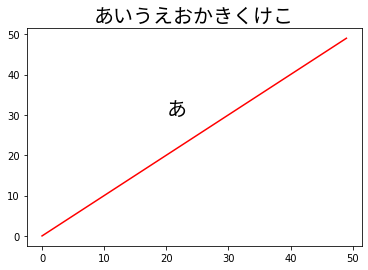

In [5]:
# Download the fonts and move to the user font directory
!yes | wget https://fonts.google.com/download?family=Noto%20Sans%20JP -O Noto_Sans_JP.zip
!unzip Noto_Sans_JP.zip
!mv *.otf /usr/share/fonts/truetype/

# Verify below with a sample plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Create FontProperties object using the file
path = '/usr/share/fonts/truetype/NotoSansJP-Regular.otf'
fontprop = fm.FontProperties(fname=path)

# Test
plt.plot(range(50), range(50), 'r')
plt.title('あいうえおかきくけこ', fontproperties=fontprop, fontsize=20)
plt.annotate('あ', (20, 30), fontproperties=fontprop, fontsize=20)
plt.show()

### Fundamentals of Deep Learning

Before we start building our deep learning model - a [Convolution Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network), or CNN - I will introduce some of the fundamental concepts of machine learning and building blocks of how neural networks work.

First we must talk about what the goals of building a predictive model in supervised learning are: to make a prediction about the target (whether that be a class label or a continuous value) and minimize the error (or, in a deep learning practitioner's parlance, the *loss*) in doing so.

In the case of simple linear models, this translates to an optimization problem where the goal is to find the *model parameters* or *coefficients* which minimize the loss - this is what the "learning" in machine learning is - the model is learning the parameters which will minimize the error of its predictions over the whole of the training data.

For a simple linear model for classification, were the goal is to predict the probability of the class label between 0 and 1, this takes the form of a [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) - a special function called the *sigmoid functions* is applied to a linear combination of our $x$ variables and also includes an intercept, $\beta_0$ and coefficients which must be learned, in the vector $\beta$:

$\hat{y} = f(x) = \frac{1}{1 + \exp{-(\beta_0 + \beta X})}$

The end result for each observation of the values for the input variables (all the $x_i$ which make up $X$) is a value between 0 and 1, output as our $\hat{y}$. This is then typically rounded up from a probability cutoff (threshold) to make what is known as a hard prediction, that of the class label; so for observations where $\hat{y} \lt 0.5$ the model would predict the observation to be of class 0, and for $\hat{y} \geq 0.5$ it would predict class 1.

In deep learning, many models are combined together in different *layers* and the outputs of previous layers are used as inputs from the next layer. Each model which makes up the different layers in the network is referred to as a *node*.

The first layer in the model, called  the *input* layer, is just a layer to take in the data. The final layer in the model, called the *output* layer, is the end result of all of the calculations from across the layers in-between - referred to as the *hidden layers* - into our final prediction, $\hat{y}$.

![diagram of neural network](img/ann_diagram.png)

Now, instead of learning the same number of coefficients for the model as input features $x_i$, each node will have its own set of coefficients (or in deep learning speak, *weights*) based upon the outputs of the previous layer.

The number of hidden layers used and the number of weights present in each - collectively, making up what is referred to as the *model architecture* - is up to the modeller.

Given this, the number of coefficients in a deep learning model tends to grow very large; it is not unusual for neural networks to have millions of weights. This is from where much of the predictive power of artifical neural network arises. It also comes at a price, as finding the optimal values for such a large number of weights to minimize the error - or *loss* - now becomes a very computationally challenging problem.   

In the Logistic Regression model as described above, a special sigmoid function is applied to the linear combination of inputs and coefficients. Furthermore adding to the computational complexity, in a deep learning model each layer can have a different function - referred to as the *activation function* - applied to the outputs of each node, which is also a combination of the inputs from the previous layer multiplied by the weights plus a bias term (intercept). It is from the application of these activation functions where the highly non-linear nature of neural networks arises, and this is also what gives them such predictive power, in addition to the very large number of weights as noted above.

In practice, there are fairly well established model architectures and families of activation functions which through research have been found to perform well for different types of machine learning problems.

In what follows, we will apply a basic convolution neural network architecture like below:



![diagram of neural network](img/cnn.jpeg)

*Image source: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53*

In the case for using image data, our input features to the network are simply the pixel values, which in black and white on a computer are represented as integers from 0-255. We can see on the right hand side, the *fully-connected* part of the network which is the same as what was discussed above.

Additionally, in a CNN architecture, there are special types of layers specifically designed to be applied to image data which is two (for black & white images) or three (for colour images) dimensional. These two types of layers are *convolutional* layers, which give the network its name, and *max pooling* layers.

The convolution layer works by sliding a *kernel* - which you can think of as a type of filter - over the image and multiplying each value (weight) in the kernel by the images in the pixel. Depending on the size of the kernel and the values, the result will have a different (usually smaller) dimensions than the original image. You can read [more on this here](https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37). This is nicely visualized in the figure below by [Vincent Dumoulin from Google Brain](https://github.com/vdumoulin/conv_arithmetic) below - the blue are the input pixels, and the cyan the output after applying a convolution:  
![convolutional neural network animated gif](img/no_padding_no_strides.gif)

What are the values in the kernel? They are learned as part of the training of the network to minimize the loss, just as the weights in other layers are.

The other type of layer specifically for image data that functions similarly is a *max pooling* layer, which is also "slid" over the image's pixel values. Here, unlike a convolutional layer, a kernel is not used but the max value in the window is taken. This is visualized in the animation below, with 2x2 max pooling applied to a 4x4 input. As such, applying max pooling results in an output smaller than the input. 

![an animated visualization of max pooling](img/maxpool.gif)

*Image source: https://nico-curti.github.io/NumPyNet/NumPyNet/layers/maxpool_layer.html*

Now that we have covered some of the fundamentals, we can proceed to applying these in code in Tensorflow and training a model for the hiragana.

### Modeling

First we will import the `Sequential` model type and the different layer types we'll need for our model:

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout

## Building a Neural Network

When working with any type of machine learning, there are generally three steps to the workflow:

1. Create the model
2. Train the model
3. Evaluate the model

For deep learning, in Step #1, this is where are generally concerned with the structure of the network we want to craft (the model architecture).

To get started, we are going to build a very simple CNN - in fact one I would call a 'toy' model. This is very similar to what appears in the [Tensorflow CNN tutorial](https://www.tensorflow.org/tutorials/images/cnn), and is simple composed of 2 convolutional layer with max pooling layers in between, and one dense / fully-connected layer after flattening.

### 1. Create the Model

First, we need to check the input of our data:

In [7]:
input_shape = X_train.shape
print(input_shape)

(232365, 28, 28)


Great, next we will create the model object. In Tensorflow the vast majority of deep learning models (including CNNs) which flow from left to right are in the `Sequential` class: 

In [8]:
ks_model = Sequential()

Now we can set up the model architecture. We do this using the [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D), [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), and [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer types from Tensorflow. For our network, we will just be using regular [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) as our activation function.

In [9]:
ks_model.add(Input(shape=(28, 28, 1)))
ks_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
ks_model.add(MaxPooling2D(pool_size=(2, 2)))
ks_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
ks_model.add(MaxPooling2D(pool_size=(2, 2)))
ks_model.add(Flatten())
ks_model.add(Dense(49, activation="softmax"))

Finally, we need to compile our model, which necessitates attaching a *loss* - a measure of how wrong we are / the error metric for the model; an *optimizer* - which, for the purposes of our discussion, is a numerical solver used to train the model; and *metrics* - to measure our model's performance. Here since we are doing a classification problem, we'll be using categorical cross-entropy and accuracy as our metric. The `adam` optimizer is fairly standard and performs well:

In [10]:
ks_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Now that we've compiled the model, we can have Tensorflow summarize the model architecture for us, which includes a high-level overview of the model, as well as some calculations on the number of model parameters (weights):

In [11]:
ks_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 49)                7

We can see here for our model, there 97,265 model parameters to be learned! Again, deep learning models can get quite large, and it is common for them to have millions of parameters.

### 2. Train the Model

Now that are model is initialized, we are ready to train the model. In Keras / Tensorflow, this is a simple as calling `model.fit()`!

Deep learning models are trained in *epochs*, where small *batches* of data are fed to the model at a time. Over each epoch, the weights are updated to reduce the loss (error). In each epoch, the model will have seen every observation in the training set. 

The results of the model training - including the performance for each epoch, which is what we are interested in - are saved in a `history` object. We also specify the `validation_split` parameter, which is the percentage of data set aside from the training set to evaluate our model performance against in each epoch (*i.e.* the model is not being fit with this data, only evaluated against it).

Here we will train our model for 10 epochs with a validation set of 30%:

In [12]:
history = ks_model.fit(X_train, y_train, epochs=10, validation_split=0.3)

Epoch 1/10
5083/5083 [==============================] - 34s 6ms/step - loss: 0.7230 - accuracy: 0.8250 - val_loss: 0.4164 - val_accuracy: 0.8832
Epoch 2/10
5083/5083 [==============================] - 31s 6ms/step - loss: 0.3429 - accuracy: 0.9051 - val_loss: 0.3335 - val_accuracy: 0.9091
Epoch 3/10
5083/5083 [==============================] - 26s 5ms/step - loss: 0.2741 - accuracy: 0.9227 - val_loss: 0.3003 - val_accuracy: 0.9205
Epoch 4/10
5083/5083 [==============================] - 33s 7ms/step - loss: 0.2371 - accuracy: 0.9320 - val_loss: 0.2964 - val_accuracy: 0.9224
Epoch 5/10
5083/5083 [==============================] - 27s 5ms/step - loss: 0.2146 - accuracy: 0.9374 - val_loss: 0.3026 - val_accuracy: 0.9211
Epoch 6/10
5083/5083 [==============================] - 26s 5ms/step - loss: 0.1961 - accuracy: 0.9423 - val_loss: 0.3066 - val_accuracy: 0.9225
Epoch 7/10
5083/5083 [==============================] - 27s 5ms/step - loss: 0.1805 - accuracy: 0.9471 - val_loss: 0.3330 - val_ac

Using the GPU power of Colab, each epoch of training only took about 30 seconds. We can also see that the model accuracy is quite high - at the end of training it appears we are able to correctly classify the hiragana with over 95% accuracy! We should dig deeper here...

We can see the history object contains, the loss and accuracy for both the training data and the validation data:

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Now let's plot the *learning curves* to see how the model performance evolved over the course of training, both when evaluated against the training data (the data the model has already seen) and the data which was set aside (the validation set):

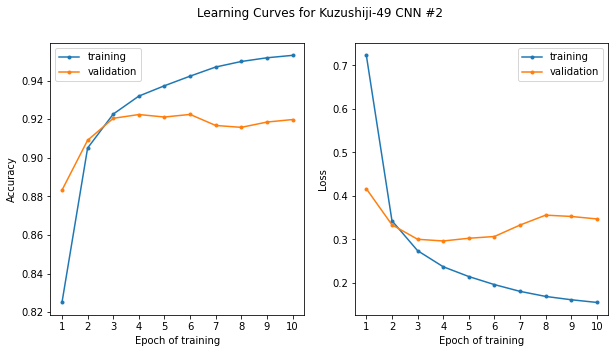

In [14]:
epochs = np.arange(10) + 1

plt.subplots(1,2, figsize=(10, 5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs, history.history['accuracy'], marker='.', label='training')
plt.plot(epochs, history.history['val_accuracy'], marker='.', label='validation')
plt.xlabel('Epoch of training')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs, history.history['loss'], marker='.', label='training')
plt.plot(epochs, history.history['val_loss'], marker='.', label='validation')
plt.xlabel('Epoch of training')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.suptitle('Learning Curves for Kuzushiji-49 CNN #2')
plt.show()

Hmm, well there's good news and bad news. The good news is, as we noted before, that our model is over 95% accurate! The bad news is that performance was attained only after one epoch of training. We can see that for epochs 2-10, the training performance increases, however the validation performance (the performance of the model on data it *has not seen*) does not improve; in fact, if anything it appears to be getting worse.

This is a hallmark case of [overfitting](https://en.wikipedia.org/wiki/Overfitting), the bane of the machine learning practitioner's existence. The model is learning the particulars of the data it is seeing (being trained upon), not the overall patterns that make up the underlying phenomena, in this case, how hiragana are trained.

To combat this, we will introduce a neural network technique called *dropout* - here some of the nodes are randomly "switched off" during training - research has shown that this is an effective way to reduce overfitting in neural networks, or a type of *regularization* (generally speaking, any changes made to way the model training occurs to reduce overfitting).

In Tensorflow, this is implemented as a [type of layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) randomly setting a proportion of the outputs of the previous layer to zero, which is equivalent to the previous layer having those weights set to zero. 

We can now update our model architecture to include dropout, and hopefully this should help with the overfitting. We will apply a dropout of 30% to each convolutional layer:

In [15]:
ks_model = Sequential()

ks_model.add(Input(shape=(28, 28, 1)))
ks_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
ks_model.add(Dropout(0.3))
ks_model.add(MaxPooling2D(pool_size=(2, 2)))
ks_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
ks_model.add(Dropout(0.3))
ks_model.add(MaxPooling2D(pool_size=(2, 2)))
ks_model.add(Flatten())
ks_model.add(Dense(49, activation="softmax"))

ks_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

ks_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 dropout (Dropout)           (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

Now we can train the model again from the start with dropout added:

In [16]:
history = ks_model.fit(X_train, y_train, epochs=10, validation_split=0.3)

Epoch 1/10
5083/5083 [==============================] - 32s 6ms/step - loss: 1.1137 - accuracy: 0.7516 - val_loss: 0.5628 - val_accuracy: 0.8715
Epoch 2/10
5083/5083 [==============================] - 27s 5ms/step - loss: 0.4928 - accuracy: 0.8643 - val_loss: 0.4471 - val_accuracy: 0.8938
Epoch 3/10
5083/5083 [==============================] - 27s 5ms/step - loss: 0.4244 - accuracy: 0.8816 - val_loss: 0.4137 - val_accuracy: 0.9033
Epoch 4/10
5083/5083 [==============================] - 30s 6ms/step - loss: 0.3973 - accuracy: 0.8890 - val_loss: 0.3753 - val_accuracy: 0.9065
Epoch 5/10
5083/5083 [==============================] - 28s 5ms/step - loss: 0.3744 - accuracy: 0.8953 - val_loss: 0.3653 - val_accuracy: 0.9111
Epoch 6/10
5083/5083 [==============================] - 31s 6ms/step - loss: 0.3639 - accuracy: 0.8978 - val_loss: 0.3513 - val_accuracy: 0.9146
Epoch 7/10
5083/5083 [==============================] - 27s 5ms/step - loss: 0.3515 - accuracy: 0.9012 - val_loss: 0.3244 - val_ac

And plot the learning curves for the new model with regularization applied:

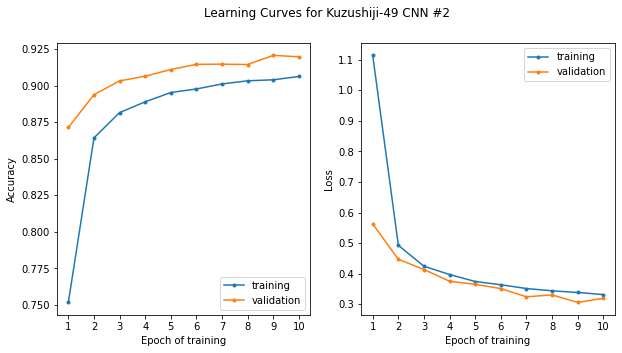

In [17]:
epochs = np.arange(10) + 1

plt.subplots(1,2, figsize=(10, 5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs, history.history['accuracy'], marker='.', label='training')
plt.plot(epochs, history.history['val_accuracy'], marker='.', label='validation')
plt.xlabel('Epoch of training')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs, history.history['loss'], marker='.', label='training')
plt.plot(epochs, history.history['val_loss'], marker='.', label='validation')
plt.xlabel('Epoch of training')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.suptitle('Learning Curves for Kuzushiji-49 CNN #2')
plt.show()

Here now with overfitting added, we see that the validation score is actually *higher* than the training score and the error (loss) lower. There are [a number of reasons for this](https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss). The important thing is that the training and validation scores are now tracking together.

The validation scores actually closely follow the gradual improvement we saw initially (even with the model overfitting on the training data), gradually improving from about 88% to around 92%. I am getting to the point where I am ready to say "good enough" for this simple illustration and our problem. That being said, there are benchmark scores with more advanced architectures for Kuzushiji-49 [as high as 97.3%](https://github.com/rois-codh/kmnist#benchmarks--results-). We are still beating the benchmark Keras CNN score listed there, however, of ~89.4%. We should bear in mind, however, that this is the score on the validation set, and not the test set.

Now we'll evaluate our model performance properly and thoroughly in the following section.

First, we'll save our model here for later use:

In [18]:
ks_model.save('model')

In [19]:
!ls

drive  model  Noto_Sans_JP.zip	OFL.txt  sample_data


In [20]:
!mv model /content/drive/MyDrive/kuzushiji/model

mv: inter-device move failed: 'model' to '/content/drive/MyDrive/kuzushiji/model/model'; unable to remove target: Directory not empty


In [21]:
!ls drive/MyDrive/kuzushiji/model

assets	fingerprint.pb	keras_metadata.pb  model  saved_model.pb  variables


In [22]:
!du drive/MyDrive/kuzushiji/model -hS

4.0K	drive/MyDrive/kuzushiji/model/assets
1.2M	drive/MyDrive/kuzushiji/model/variables
1.2M	drive/MyDrive/kuzushiji/model/model/variables
4.0K	drive/MyDrive/kuzushiji/model/model/assets
158K	drive/MyDrive/kuzushiji/model/model
158K	drive/MyDrive/kuzushiji/model


### Evaluating Model Performance

In [23]:
y_proba = ks_model.predict(X_test)

1205/1205 [==============================] - 2s 2ms/step


In [24]:
y_proba.shape

(38547, 49)

In [25]:
y_pred = y_proba.argmax(axis=1)

# Check
y_pred

array([19, 20, 10, ...,  1, 22, 47])

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [27]:
accuracy_score(y_test, y_pred)

0.8569279061924404

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1000
           1       0.95      0.95      0.95      1000
           2       0.88      0.96      0.91      1000
           3       0.63      0.89      0.74       126
           4       0.89      0.87      0.88      1000
           5       0.79      0.81      0.80      1000
           6       0.84      0.84      0.84      1000
           7       0.87      0.87      0.87      1000
           8       0.68      0.75      0.72       767
           9       0.89      0.81      0.85      1000
          10       0.92      0.83      0.87      1000
          11       0.89      0.89      0.89      1000
          12       0.75      0.82      0.78      1000
          13       0.89      0.70      0.79       678
          14       0.83      0.71      0.77       629
          15       0.91      0.80      0.85      1000
          16       0.85      0.96      0.90       418
          17       0.86    

In [29]:
class_report = classification_report(y_test, y_pred, output_dict=True)

In [30]:
report_df = pd.DataFrame(class_report).T

report_df.head()

,precision,recall,f1-score,support
0,0.867357,0.922000,0.893844,1000.0
1,0.948310,0.954000,0.951147,1000.0
2,0.875572,0.957000,0.914477,1000.0
3,0.629213,0.888889,0.736842,126.0
4,0.892638,0.873000,0.882710,1000.0


In [31]:
report_df.tail(3)

,precision,recall,f1-score,support
accuracy,0.856928,0.856928,0.856928,0.856928
macro avg,0.848763,0.851143,0.847979,38547.000000
weighted avg,0.860504,0.856928,0.857040,38547.000000


In [32]:
report_df = report_df[:-3]

In [33]:
report_df.tail()

,precision,recall,f1-score,support
44,0.742424,0.720588,0.731343,68.0
45,0.753623,0.812500,0.781955,64.0
46,0.874140,0.889000,0.881507,1000.0
47,0.929457,0.975000,0.951684,1000.0
48,0.817241,0.825784,0.821490,574.0


In [34]:
classmap.index = classmap.index.astype(str)

In [35]:
report_df_joined = report_df.join(classmap)
report_df_joined.head()

,precision,recall,f1-score,support,index,codepoint,char
0,0.867357,0.922000,0.893844,1000.0,0,U+3042,あ
1,0.948310,0.954000,0.951147,1000.0,1,U+3044,い
2,0.875572,0.957000,0.914477,1000.0,2,U+3046,う
3,0.629213,0.888889,0.736842,126.0,3,U+3048,え
4,0.892638,0.873000,0.882710,1000.0,4,U+304A,お


In [36]:
report_df.index = report_df.index.map(classmap['char'])

In [37]:
report_df

,precision,recall,f1-score,support
あ,0.867357,0.922000,0.893844,1000.0
い,0.948310,0.954000,0.951147,1000.0
う,0.875572,0.957000,0.914477,1000.0
え,0.629213,0.888889,0.736842,126.0
お,0.892638,0.873000,0.882710,1000.0
か,0.794291,0.807000,0.800595,1000.0
き,0.842158,0.843000,0.842579,1000.0
く,0.869478,0.866000,0.867735,1000.0
け,0.684524,0.749674,0.715619,767.0
こ,0.893688,0.807000,0.848135,1000.0


In [96]:
import matplotlib.font_manager as fm
fm._rebuild()

In [97]:
[f for f in fm.fontManager.ttflist if 'Noto' in f.name]

[<Font 'Noto Sans JP' (NotoSansJP-Regular.otf) normal normal 400 normal>,
 <Font 'Noto Sans JP' (NotoSansJP-Black.otf) normal normal black normal>,
 <Font 'Noto Sans JP' (NotoSansJP-Light.otf) normal normal light normal>,
 <Font 'Noto Sans JP' (NotoSansJP-Medium.otf) normal normal medium normal>,
 <Font 'Noto Sans JP' (NotoSansJP-Bold.otf) normal normal 700 normal>,
 <Font 'Noto Sans JP' (NotoSansJP-Thin.otf) normal normal 400 normal>]

In [98]:
import matplotlib
matplotlib.rcParams['font.family'] = ['Noto Sans JP']

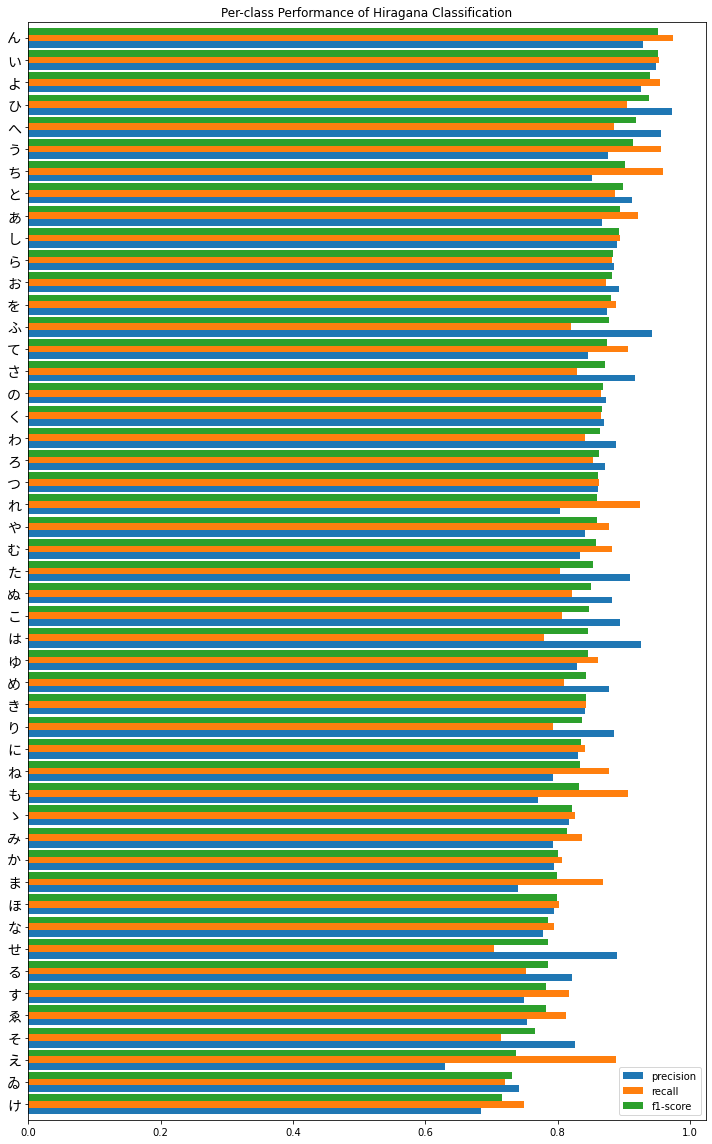

In [121]:
# Recall
report_df.drop('support', axis=1).sort_values(by='f1-score').plot(kind='barh', width=0.9, figsize=(10, 16))
plt.yticks(fontproperties=fontprop, fontsize=14)
plt.title('Per-class Performance of Hiragana Classification')
plt.tight_layout()
plt.show()

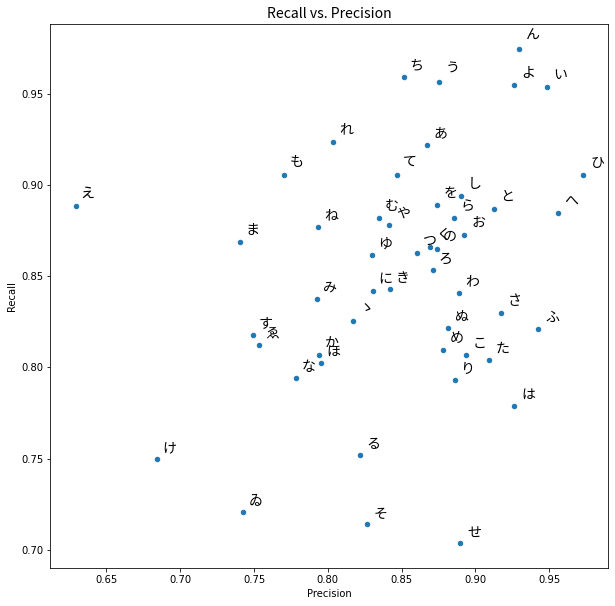

In [122]:
#matplotlib.rcParams['font.sans-serif'] = ['Noto Sans Japanese', 'sans-serif']

plt.figure(figsize=(10, 10))
plt.scatter(report_df_joined['precision'], report_df_joined['recall'], s=20)

for i in np.arange(49).astype(str):
    plt.annotate(report_df_joined.loc[i,'char'], (report_df_joined.loc[i, 'precision']*1.005, report_df_joined.loc[i, 'recall']*1.005),
                fontsize=14, fontproperties=fontprop)
    
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title("Recall vs. Precision", fontproperties=fontprop)


plt.show()

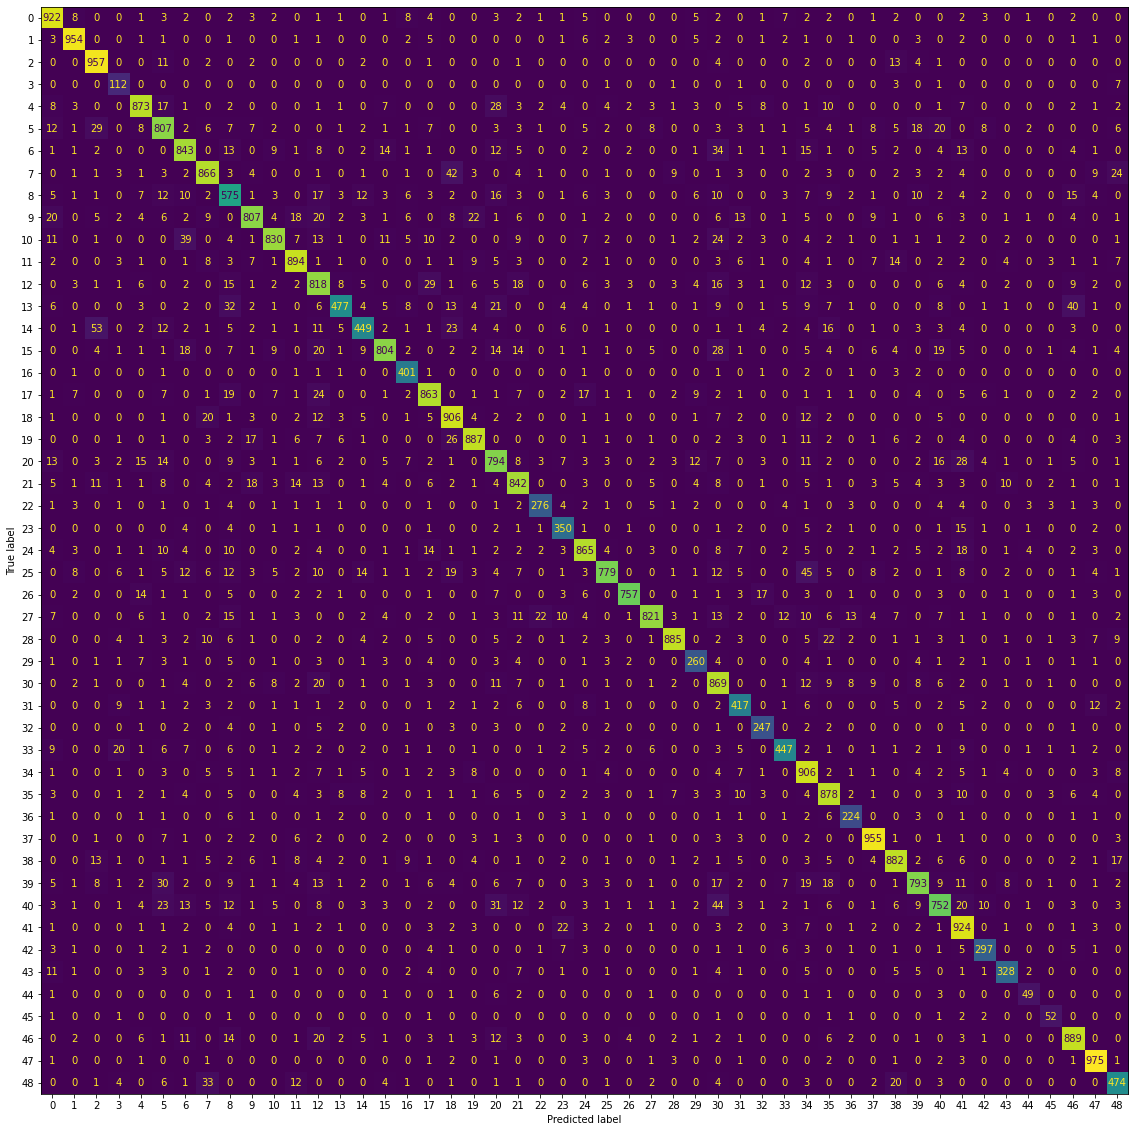

In [123]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(20, 20))
ax = plt.gca()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)
plt.show()

In [124]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a dataframe
cm_df = pd.DataFrame(cm, columns=classmap['char'], index=classmap['char'])

# Normalize by percentage of true values captured (recall)
cm_df_norm = cm_df/cm_df.sum(axis=1)

# Check
cm_df_norm.head()

char,あ,い,う,え,お,か,き,く,け,こ,...,り,る,れ,ろ,わ,ゐ,ゑ,を,ん,ゝ
char,,,,,,,,,,,,,,,,,,,,,
あ,0.922,0.008,0.000,0.000000,0.001,0.003,0.002,0.000,0.002608,0.003,...,0.000,0.000,0.002,0.008621,0.0,0.014706,0.0,0.002,0.000,0.000000
い,0.003,0.954,0.000,0.000000,0.001,0.001,0.000,0.000,0.001304,0.000,...,0.003,0.000,0.002,0.000000,0.0,0.000000,0.0,0.001,0.001,0.000000
う,0.000,0.000,0.957,0.000000,0.000,0.011,0.000,0.002,0.000000,0.002,...,0.004,0.001,0.000,0.000000,0.0,0.000000,0.0,0.000,0.000,0.000000
え,0.000,0.000,0.000,0.888889,0.000,0.000,0.000,0.000,0.000000,0.000,...,0.000,0.001,0.000,0.000000,0.0,0.000000,0.0,0.000,0.000,0.012195
お,0.008,0.003,0.000,0.000000,0.873,0.017,0.001,0.000,0.002608,0.000,...,0.000,0.001,0.007,0.000000,0.0,0.000000,0.0,0.002,0.001,0.003484


In [180]:
# Unstack the dataframe
flattened = pd.DataFrame(cm_df_norm.unstack())

# Rename the multi-index
flattened.index = flattened.index.rename('char1', 0).rename('char2', 1)

# Rest to remove the multi-index
flattened = flattened.reset_index().rename({0:'pct'}, axis=1)

# Check
flattened.head()

<ipython-input-180-fc7116d0e717>:5: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_names except for the argument 'names' will be keyword-only
  flattened.index = flattened.index.rename('char1', 0).rename('char2', 1)


,char1,char2,pct
0,あ,あ,0.922
1,あ,い,0.003
2,あ,う,0.000
3,あ,え,0.000
4,あ,お,0.008


In [181]:
# Keep only rows not on the original diagonal
flattened = flattened[flattened['char1'] != flattened['char2']]

# Create a new index of pairs for plotting
flattened.index = "True:" + flattened['char1'] + " Predicted:" + flattened['char2']
flattened.drop(['char1', 'char2'], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


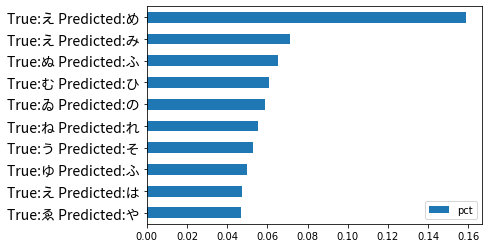

In [186]:
# Find Top 10 greatest and plot
flattened.sort_values(by='pct').nlargest(10, 'pct').sort_values(by='pct', ascending=True).plot(kind='barh')
plt.yticks(fontproperties=fontprop)
plt.show()

We can see that 'e' (え) is frequently mistaken for 'me' (め) and 'mi' (み). Let's take a look at this misclassifications and see if there is anything notable visually.

In [192]:
classmap[classmap['char'].isin(['み', 'め', 'え'])]

,index,codepoint,char
3,3,U+3048,え
31,31,U+307F,み
33,33,U+3081,め


We should be looking for rows in `y_test` where the class label is 3 for *e* and the class label in `y_pred` is 31 or 33 for *mi* or *me*.

In [197]:
y_test.shape

(38547,)

In [217]:
# Create a dataframe of the true and predicted values
pred_df = pd.DataFrame({'true':y_test, 'predicted':y_pred})

# Create columns holding the true and predicated characters
pred_df['true_char'] = pred_df['true'].astype(str).map(classmap['char'])
pred_df['pred_char'] = pred_df['predicted'].astype(str).map(classmap['char'])

# Check
pred_df.head()

,true,predicted,true_char,pred_char
0,19,19,と,と
1,23,20,ね,な
2,10,10,さ,さ
3,31,33,み,め
4,26,26,ひ,ひ


Now we can easily pull out the indices for the images we want to look at:

In [245]:
ku_df = pred_df[((pred_df['true_char']=='け') & (pred_df['pred_char']!='け'))]

ku_df.head(5)

,true,predicted,true_char,pred_char
44,8,4,け,お
291,8,6,け,き
307,8,4,け,お
471,8,16,け,ち
805,8,29,け,ほ


In [247]:
# Find the distinct other characters
wrong_chars = ku_df['pred_char'].unique()

print(wrong_chars)

['お' 'き' 'ち' 'ほ' 'を' 'も' 'り' 'こ' 'か' 'な' 'そ' 'は' 'す' 'や' 'の' 'ん' 'ま' 'め'
 'ろ' 'た' 'に' 'う' 'せ' 'つ' 'い' 'さ' 'て' 'よ' 'る' 'れ' 'ね' 'あ' 'ゆ' 'く']


True: け, Predicted: お
Indices: Int64Index([44, 307, 1915, 3339, 16560, 16657, 27842], dtype='int64')


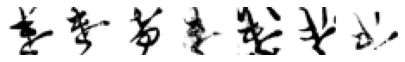

True: け, Predicted: き
Indices: Int64Index([291, 8912, 11578, 13587, 15961, 20647, 25308, 26724, 27606, 35526], dtype='int64')


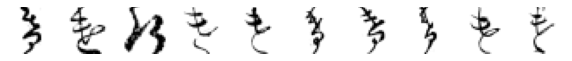

True: け, Predicted: ち
Indices: Int64Index([471, 11058, 20644, 20883, 34393, 38542], dtype='int64')


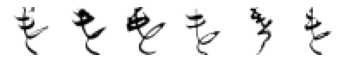

True: け, Predicted: ほ
Indices: Int64Index([805, 3790, 22445, 23641, 24914, 36527], dtype='int64')


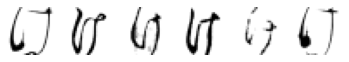

True: け, Predicted: を
Indices: Int64Index([ 1069,  1509,  5749, 12124, 14118, 14238, 17664, 19083, 19089,
            27045, 28411, 28961, 33483, 36193, 36329],
           dtype='int64')


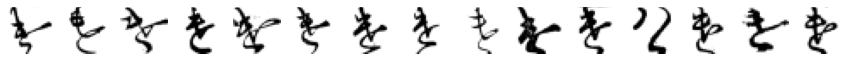

True: け, Predicted: も
Indices: Int64Index([1385, 1526, 3051, 10887, 11074, 15969, 18819], dtype='int64')


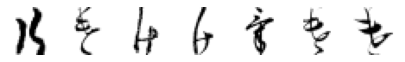

True: け, Predicted: り
Indices: Int64Index([1458, 5009, 5641, 12396, 13623, 16427, 19191, 31766, 37347, 37579], dtype='int64')


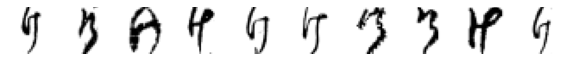

True: け, Predicted: こ
Indices: Int64Index([2111], dtype='int64')


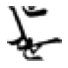

True: け, Predicted: か
Indices: Int64Index([2387, 4304, 6809, 9539, 10019, 11496, 12403, 20112, 26467, 32962,
            35718, 37848],
           dtype='int64')


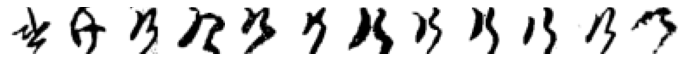

True: け, Predicted: な
Indices: Int64Index([ 2418,  2427,  5771,  7169,  7629, 12740, 23657, 25053, 25399,
            25823, 27855, 27966, 33982, 35843, 36994, 37441],
           dtype='int64')


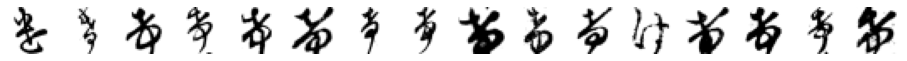

True: け, Predicted: そ
Indices: Int64Index([2524, 2569, 6033, 11194, 13286, 18873, 19045, 20997, 21667, 23422,
            23527, 24208],
           dtype='int64')


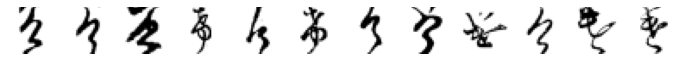

True: け, Predicted: は
Indices: Int64Index([2542, 20740, 24760], dtype='int64')


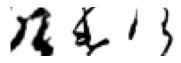

True: け, Predicted: す
Indices: Int64Index([ 2545,  3156,  7260,  8660,  9098, 12627, 13544, 16502, 17914,
            21117, 21664, 27977, 33142, 33224, 35226, 36215, 38076],
           dtype='int64')


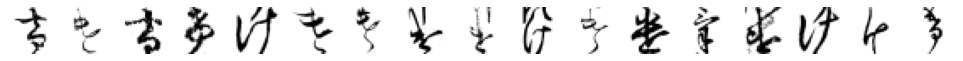

True: け, Predicted: や
Indices: Int64Index([3559, 5720, 9095, 24867, 30354, 30949, 33108, 33750, 35034], dtype='int64')


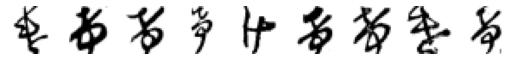

True: け, Predicted: の
Indices: Int64Index([3933, 9331, 11127, 24286, 26858, 28760], dtype='int64')


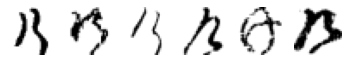

True: け, Predicted: ん
Indices: Int64Index([4663, 11863, 22248, 26797], dtype='int64')


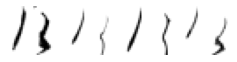

True: け, Predicted: ま
Indices: Int64Index([5969, 6056, 8972, 10261, 21130, 22371, 33736, 35061, 36298, 37799], dtype='int64')


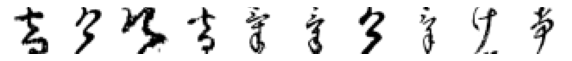

True: け, Predicted: め
Indices: Int64Index([6023, 12574, 21683], dtype='int64')


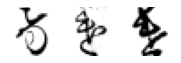

True: け, Predicted: ろ
Indices: Int64Index([8196, 13596], dtype='int64')


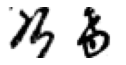

True: け, Predicted: た
Indices: Int64Index([8469, 9230, 31426], dtype='int64')


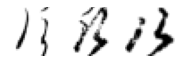

True: け, Predicted: に
Indices: Int64Index([10095, 12287, 19582], dtype='int64')


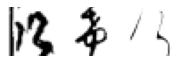

True: け, Predicted: う
Indices: Int64Index([11364], dtype='int64')


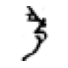

True: け, Predicted: せ
Indices: Int64Index([13630, 18372, 21608], dtype='int64')


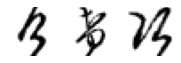

True: け, Predicted: つ
Indices: Int64Index([14513, 24177, 34994], dtype='int64')


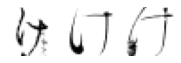

True: け, Predicted: い
Indices: Int64Index([14677], dtype='int64')


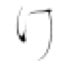

True: け, Predicted: さ
Indices: Int64Index([15608, 16782, 20618], dtype='int64')


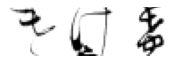

True: け, Predicted: て
Indices: Int64Index([16121, 27145], dtype='int64')


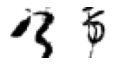

True: け, Predicted: よ
Indices: Int64Index([18300], dtype='int64')


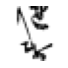

True: け, Predicted: る
Indices: Int64Index([19250, 28596], dtype='int64')


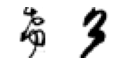

True: け, Predicted: れ
Indices: Int64Index([19762, 26067, 30461, 34716], dtype='int64')


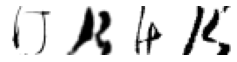

True: け, Predicted: ね
Indices: Int64Index([21301], dtype='int64')


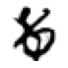

True: け, Predicted: あ
Indices: Int64Index([22047, 24107, 30632, 34896, 36275], dtype='int64')


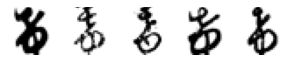

True: け, Predicted: ゆ
Indices: Int64Index([23492, 23522], dtype='int64')


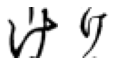

True: け, Predicted: く
Indices: Int64Index([30946, 37192], dtype='int64')


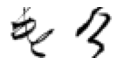

In [283]:
for wrong_char in wrong_chars:

  wrong_index = ku_df[ku_df['pred_char']==wrong_char].index
  n = len(wrong_index)

  # Code from Part 1
  fig, axes = plt.subplots(n, 1, figsize=(n, 1))

  print('True: け, Predicted: ' + wrong_char)
  print('Indices:', wrong_index)

  # Iterate over of the sample images per class and add to the subplot grid 
  for j in range(0, n):
      plt.subplot(1, n, j+1)
      plt.imshow(X_test[wrong_index[j], :, :], cmap='gray_r')
      plt.axis('off') # hide axes
  plt.show()